# Env setupu

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import plotly.express as px
from anndata import AnnData
from sklearn.neighbors import KernelDensity
import random
from matplotlib import pylab
import warnings
import scanpy.external as sce 
import pyranges as pr
import yaml
from matplotlib.colors import TwoSlopeNorm
from pyliftover import LiftOver


import seaborn as sns
import os
import sys

warnings.filterwarnings('ignore')

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
sc.settings.verbosity = 3  
sc.logging.print_header()
nprocs=4
np.random.seed(0)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


# Configure paths

In [7]:
outdir = "../data/output"

with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
colorsmap = dict(zip([i["newName"] for i in iPSC_lines_map.values()],[i["color"] for i in iPSC_lines_map.values()]))


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)


    
#tradeSeqUtilsPath = "/opt/tradeSeq_utils.R"
tradeSeqUtilsPath = "/opt/tradeSeq_utils.R"

vcfPath = "../data/jointGenotype.g.vcf"

gtfPath = "../data/resources/genes.gtf"

# sc eQTLs from jerber et al https://doi.org/10.1038/s41588-021-00801-6
scEqtlsJerber = pd.read_csv("../data/resources/Jerber_scASE.tsv", sep="\t")


# var setting

In [8]:
branchTag = "Migrating"
endpoint = "endpoint_MigratingNeurons"
markers = ["RELN","PAX6","CBLN1","MKI67","FOXP1"]
min_cells = 50
MultiTPTstages = ["early","mid"]
binWidthRate = .05
ResamplingIterations = 50
leidenOrder = ["ProliferatingProgenitors", 'RadialGliaProgenitors', 'Neurons','MigratingNeurons']


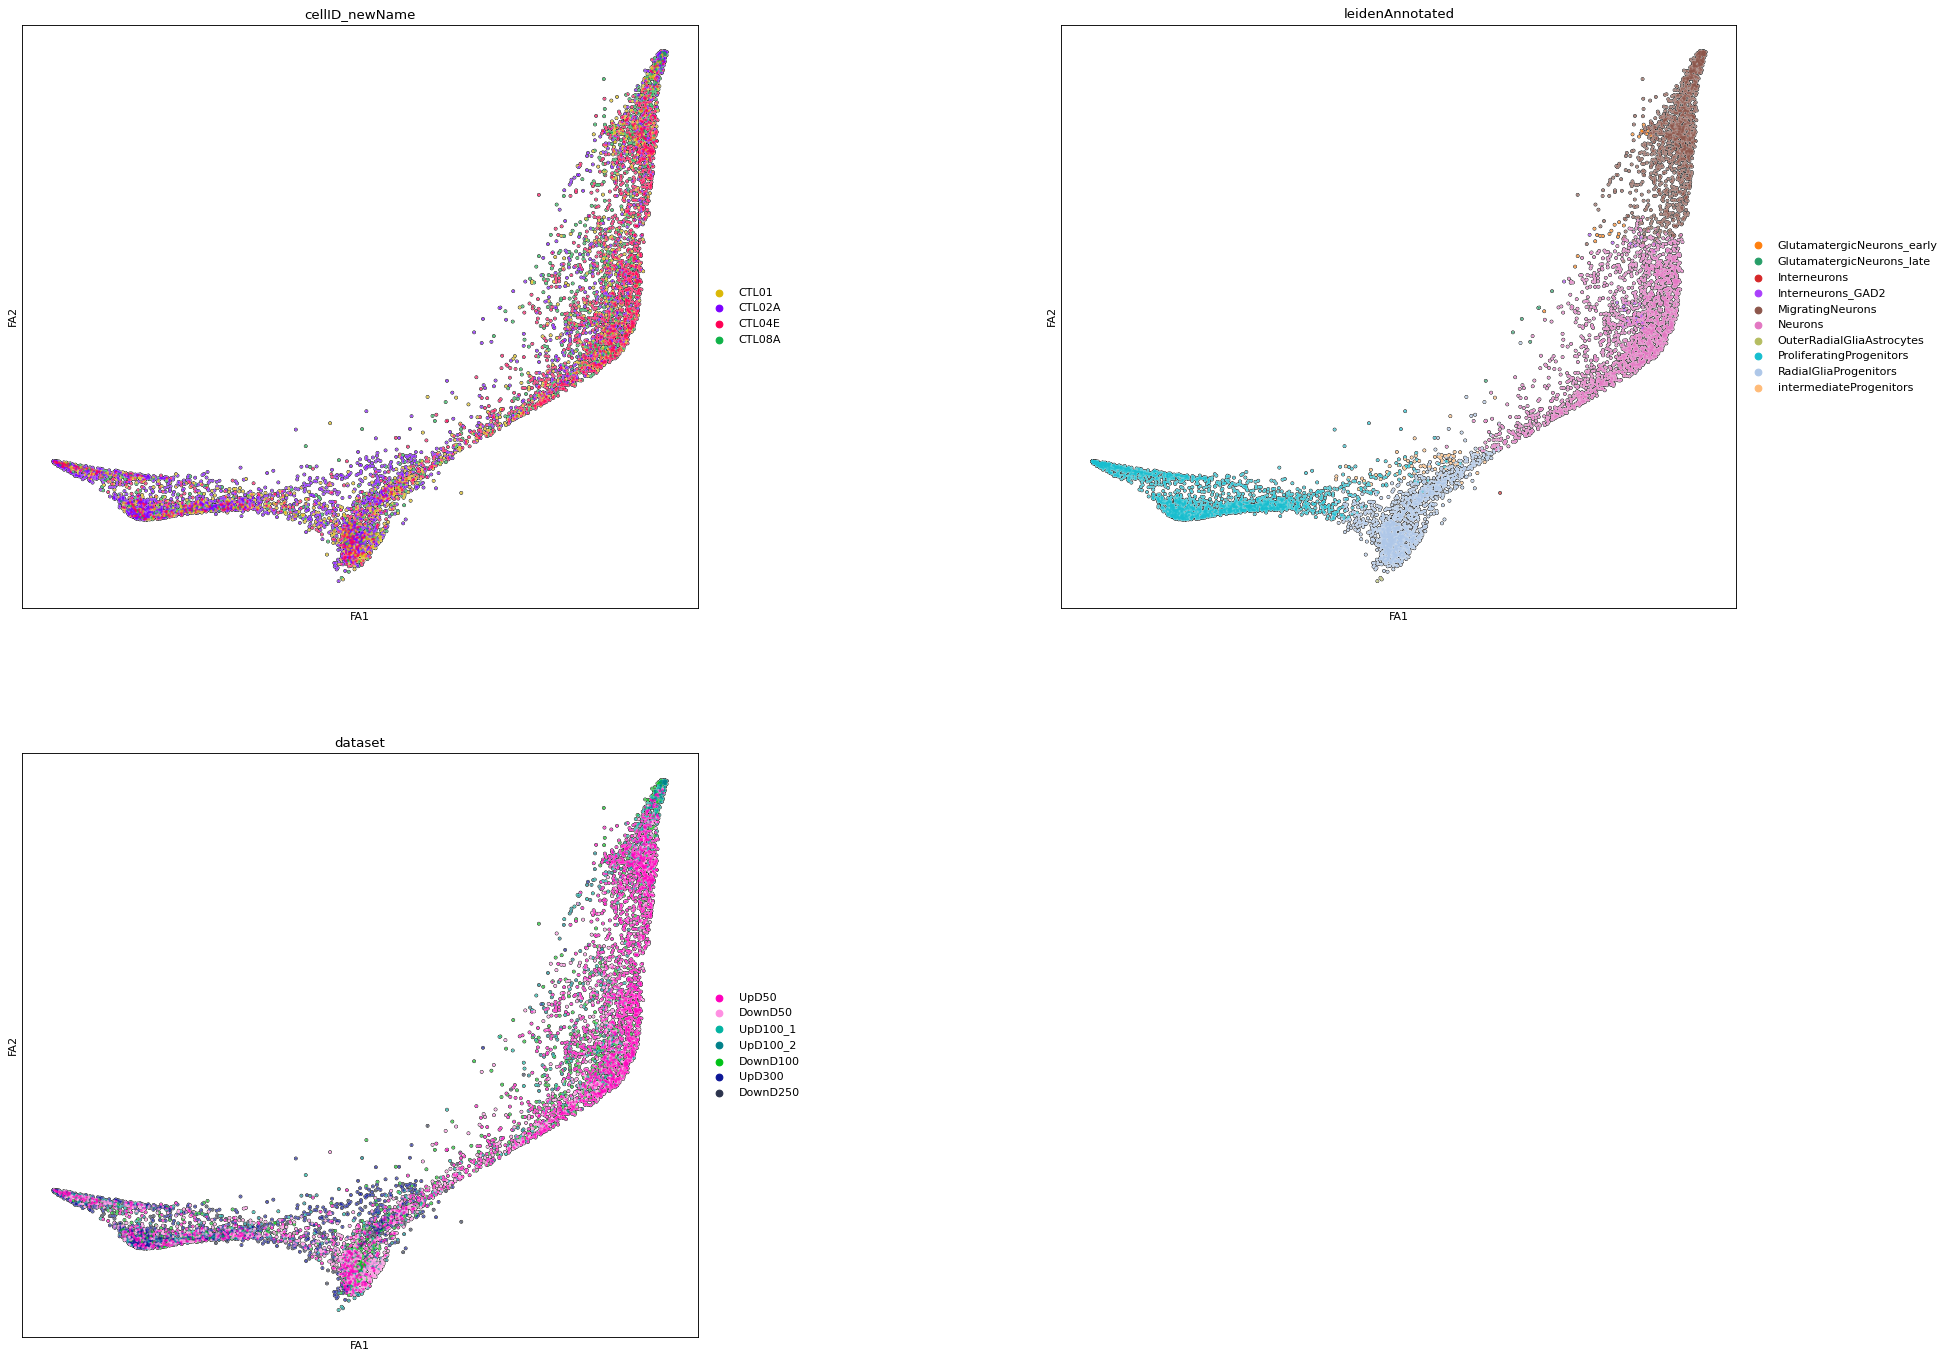

In [9]:

BranchBCs = sc.read_h5ad(outdir+"/adatas/adataPaga.h5ad")

sc.pl.draw_graph(BranchBCs[BranchBCs.obs[endpoint] == 1], color = ["cellID_newName","leidenAnnotated","dataset"],size =  rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', wspace=.4, ncols=2)

BranchBCs = BranchBCs.obs_names[BranchBCs.obs[endpoint] == 1].tolist()

harmonyTheta = 1

HVGs = pd.read_csv(outdir+"/HVG_list_intersection_Curated_"+branchTag+"_PagaTest.txt", sep = "\t")["HVG"] 

## Branch specifi pre-processing

In [10]:
adataBranch = sc.read_h5ad(outdir+'/adatas/MultiplexingPreprocessing_unscaled.h5ad')[BranchBCs]
adataBranch.obs["leidenAnnotated"] =  sc.read_h5ad(outdir+"/adatas/ClusterAnnotated_Base_filt.h5ad")[adataBranch.obs_names].obs["leidenAnnotated"]
adataBranch.uns["leidenAnnotated_colors"] =  sc.read_h5ad(outdir+"/adatas/adataPaga.h5ad")[adataBranch.obs_names].uns["leidenAnnotated_colors"]
goodcls = adataBranch.obs.groupby(["leidenAnnotated"]).size()[adataBranch.obs.groupby(["leidenAnnotated"]).size() >= 50].index.tolist()
adataBranch = adataBranch[adataBranch.obs["leidenAnnotated"].isin(goodcls)]


adataBranch.layers["unscaled"] = adataBranch.X.copy()


sc.pp.normalize_total(adataBranch, target_sum=1e4)

sc.pp.log1p(adataBranch)
adataBranch.raw = adataBranch



adataBranch = adataBranch[:,HVGs]
adataBranch.var["highly_variable"] = True
#sc.pp.highly_variable_genes(adataBranch, min_mean=0.0125, max_mean=5, min_disp=0.5, batch_key = "dataset")

sc.pp.regress_out(adataBranch, ['total_counts','pct_counts_mt'], n_jobs=4)
sc.pp.scale(adataBranch, zero_center=False)
#adataBranch.X = adataBranch.X + np.abs(adataBranch.X.min())



normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [11]:
sc.tl.pca(adataBranch, svd_solver='arpack', use_highly_variable=True)
sce.pp.harmony_integrate(adataBranch, 'dataset', max_iter_harmony=20,adjusted_basis="X_pca",random_state = 0, theta = harmonyTheta, lamb = 2)
sc.pp.neighbors(adataBranch,use_rep="X_pca",n_neighbors=50, n_pcs=10, random_state=0)

sc.tl.umap(adataBranch, random_state=0)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


2023-07-31 10:31:56,869 - harmonypy - INFO - Iteration 1 of 20
2023-07-31 10:31:57,888 - harmonypy - INFO - Iteration 2 of 20
2023-07-31 10:31:58,922 - harmonypy - INFO - Iteration 3 of 20
2023-07-31 10:31:59,949 - harmonypy - INFO - Iteration 4 of 20
2023-07-31 10:32:00,979 - harmonypy - INFO - Iteration 5 of 20
2023-07-31 10:32:01,994 - harmonypy - INFO - Iteration 6 of 20
2023-07-31 10:32:02,843 - harmonypy - INFO - Iteration 7 of 20
2023-07-31 10:32:03,507 - harmonypy - INFO - Iteration 8 of 20
2023-07-31 10:32:04,041 - harmonypy - INFO - Iteration 9 of 20
2023-07-31 10:32:04,619 - harmonypy - INFO - Iteration 10 of 20
2023-07-31 10:32:05,163 - harmonypy - INFO - Iteration 11 of 20
2023-07-31 10:32:05,650 - harmonypy - INFO - Converged after 11 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


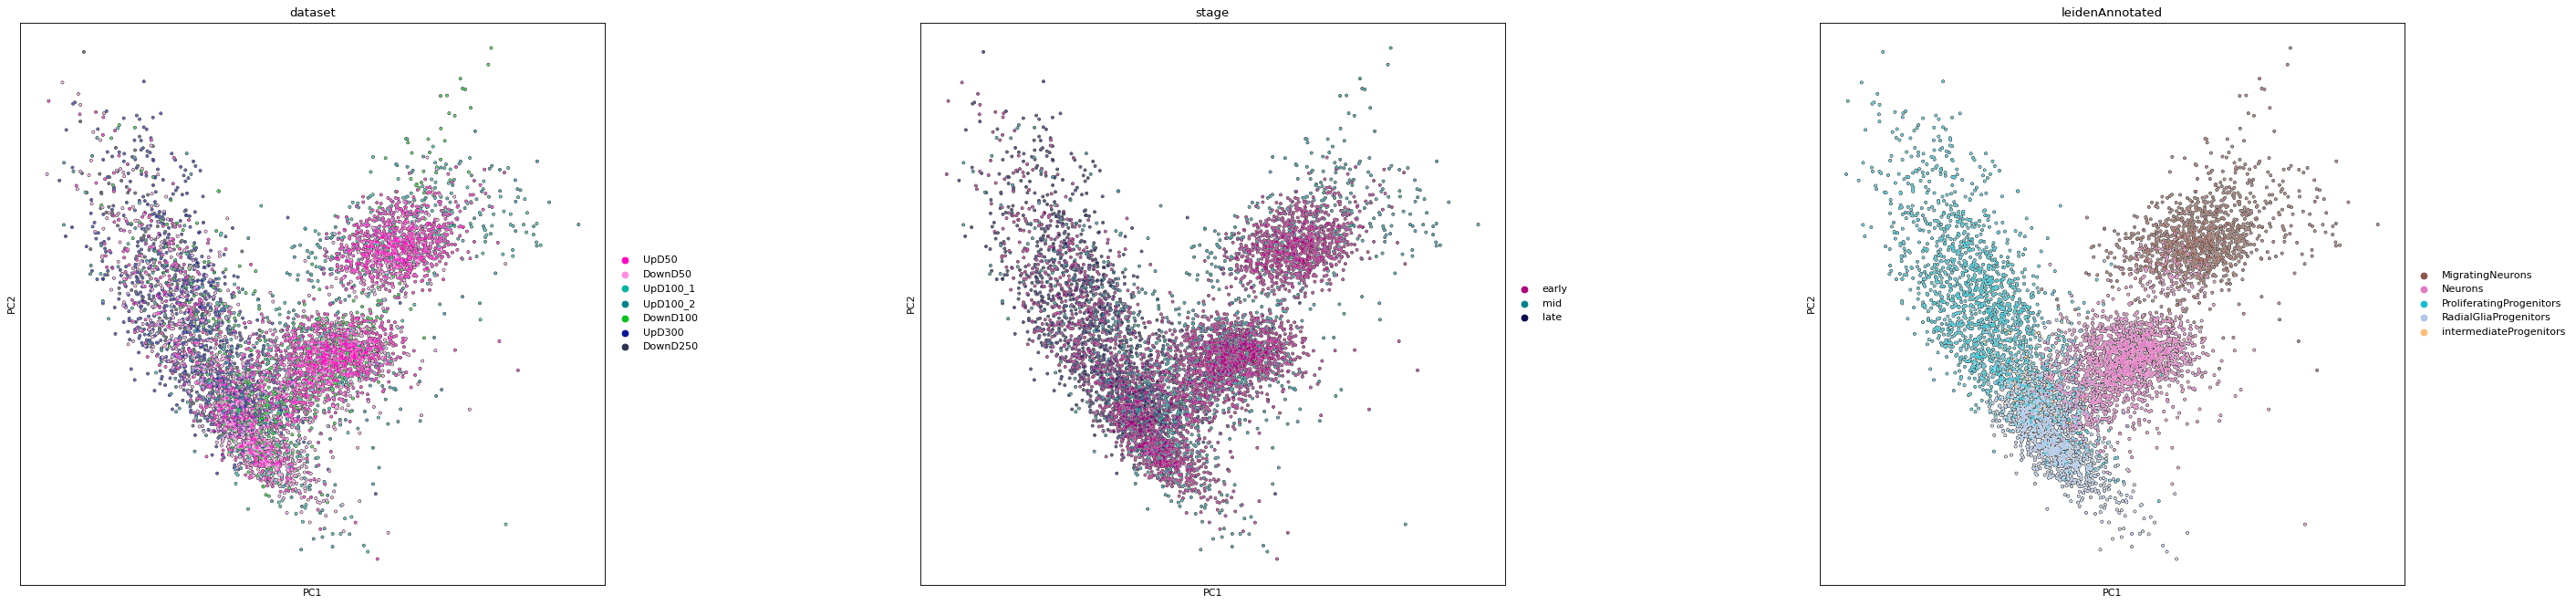

In [12]:
with open("../data/resources/CelltypeColors.yaml") as f:
    CelltypeColors = yaml.full_load(f)["leidenAnnotated_colors"]

adataBranch.uns["leidenAnnotated_colors"] = np.array([CelltypeColors[i] for i in adataBranch.obs.leidenAnnotated.cat.categories.tolist()])

sc.pl.pca(adataBranch, color = ["dataset","stage",'leidenAnnotated'], size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98',wspace=.4)

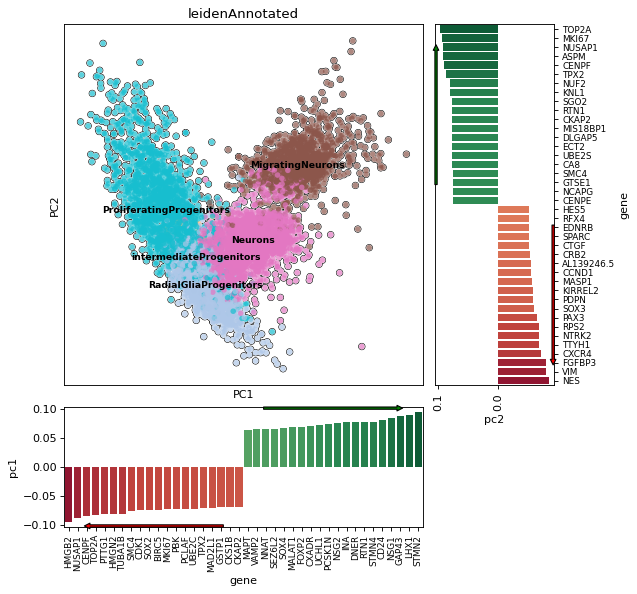

In [13]:
#if you want vector sc.settings._vector_friendly = False
vector=False
n=20
pdDict = {}

if vector:
    sc.settings._vector_friendly = False
for pc in  [0,1]:
    TopPC_IDX = np.argpartition(adataBranch.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataBranch.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataBranch.varm["PCs"][:,pc][TopPC_IDX], index = adataBranch.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataBranch.varm["PCs"][:,pc][DownPC_IDX], index = adataBranch.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == 0:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == 1:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (6, 6)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataBranch, components=['1,2'], color=["leidenAnnotated"], 
                    ncols=1, add_outline=True, legend_loc="on data",size=100,legend_fontsize="small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[0]["pc1"].min(), vcenter=0, vmax=pdDict[0]["pc1"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[0]["pc1"]]
sns.barplot(data=pdDict[0], x="gene", y="pc1", color="pc1",palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))


norm = TwoSlopeNorm(vmin=pdDict[1]["pc2"].min(), vcenter=0, vmax=pdDict[1]["pc2"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[1]["pc2"]]
sns.barplot(data=pdDict[1], x="pc2", y="gene", color="pc2",palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True


In [14]:
pdDict = {}
for pc in  [0]:
    pdDict[pc] = pd.DataFrame(adataBranch.varm["PCs"][:,pc], index = adataBranch.var_names.tolist(), columns=["loading"])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    pdDict[pc] = pdDict[pc].sort_values("loading")
    pdDict[pc]["component"] = "pc"+str(pc+1)
    
TopLoadings = pdDict[pc]
TopLoadings

loading    gene component
HMGB2  -0.094620   HMGB2       pc1
NUSAP1 -0.088932  NUSAP1       pc1
CENPF  -0.083994   CENPF       pc1
TOP2A  -0.083814   TOP2A       pc1
PTTG1  -0.081935   PTTG1       pc1
...          ...     ...       ...
CD24    0.080808    CD24       pc1
NSG1    0.084209    NSG1       pc1
GAP43   0.088641   GAP43       pc1
LHX1    0.089887    LHX1       pc1
STMN2   0.094153   STMN2       pc1

[1804 rows x 3 columns]

In [15]:
cellIDColorsMap = dict(zip(adataBranch.obs["cellID_newName"].cat.categories, adataBranch.uns["cellID_newName_colors"]))

# DPT

In [16]:
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.996359   0.9893683  0.9803064  0.9623212  0.9606392
     0.9543723  0.9420862  0.935516   0.93360186 0.92206126 0.9051535
     0.9023296  0.8995203  0.8969393 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


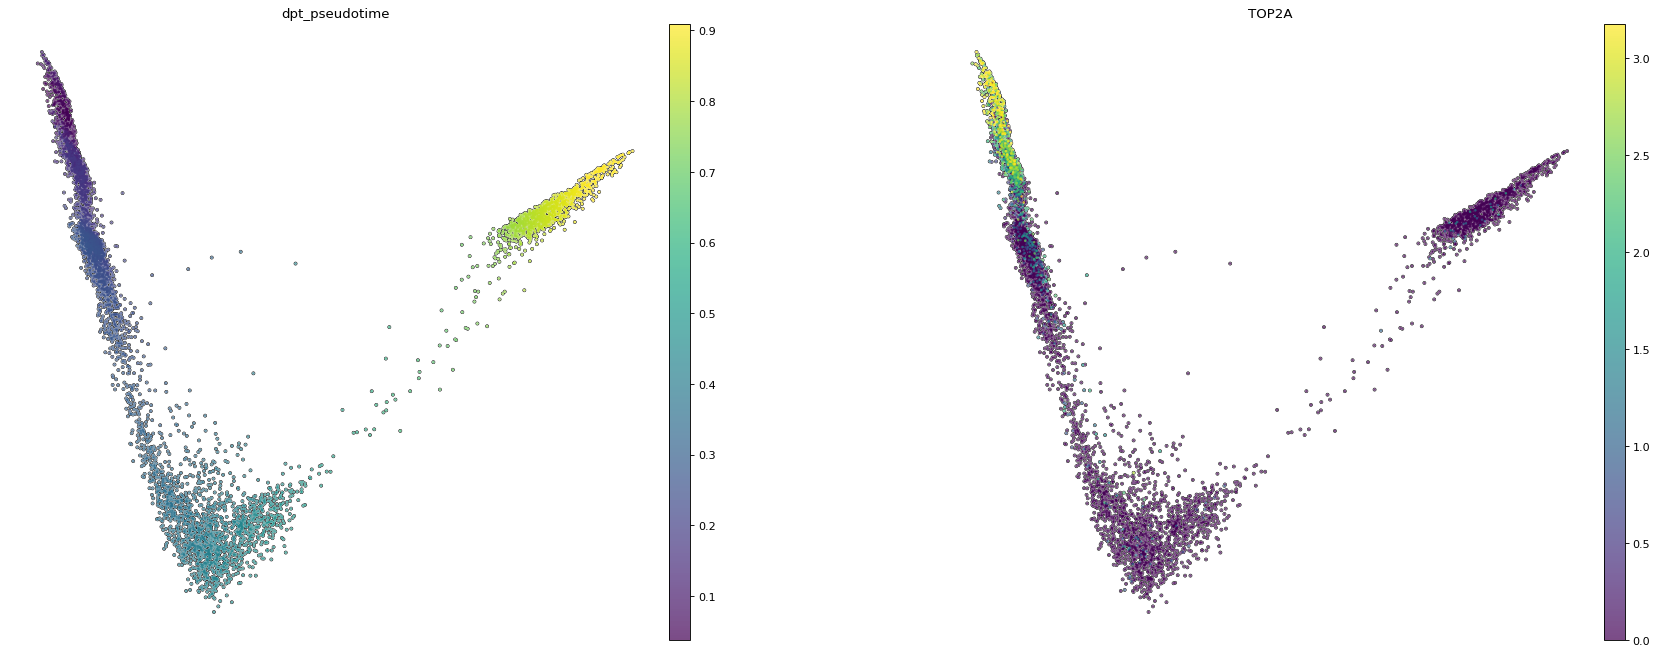

In [17]:
sc.tl.diffmap(adataBranch)


RootName = adataBranch.obs_names[adataBranch[:, ["TOP2A"]].X.argmax()]
root_idx = np.where(adataBranch.obs_names == RootName)[0][0]
adataBranch.uns['iroot'] = root_idx


sc.tl.dpt(adataBranch)
sc.pl.diffmap(adataBranch, color = ["dpt_pseudotime","TOP2A"],size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', legend_fontsize="xx-large", frameon=False, wspace=.3, legend_loc="on data")


In [18]:
adataBranch.write_h5ad(outdir+"/adatas/AdataLineage."+branchTag+".h5ad")

In [19]:
timeCov="dpt_pseudotime"


## By timepoint

In [20]:
sns.set_style("white")

In [21]:
cov = "stage"

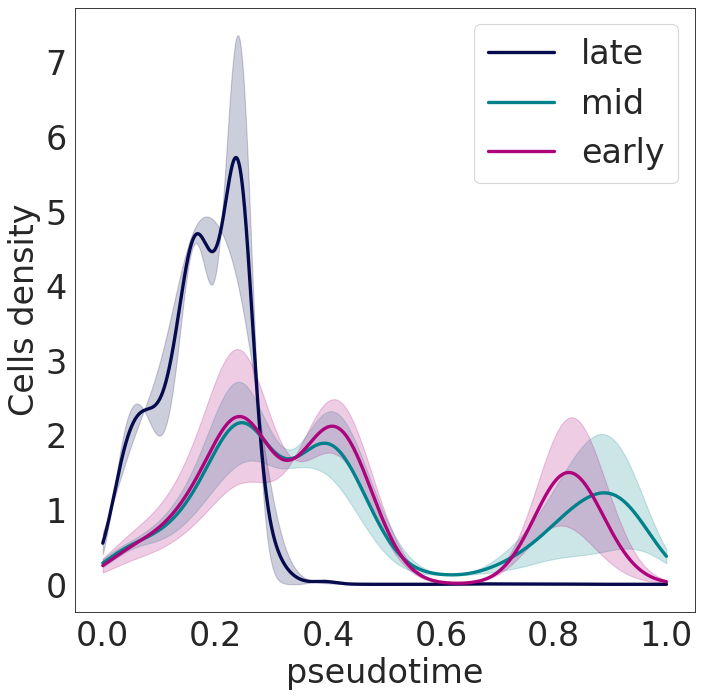

In [22]:
#errors by dataset
for Stage in adataBranch.obs["stage"].unique(): 
    StageLT = adataBranch.obs[adataBranch.obs["stage"] == Stage]
    
    StageLT_smoothed = pd.DataFrame(index=np.linspace(0, 1, 10000))
    for dataset in StageLT["dataset"].unique():
        datasetLT = StageLT.loc[StageLT["dataset"] == dataset,timeCov]
        _bandwidth = round((datasetLT.max() - datasetLT.min()) * binWidthRate, 2)
        KernelData = datasetLT

        
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(0, 1, 10000)[:, np.newaxis]

        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        
        StageLT_smoothed[dataset] = Y
        
    StageLT_smoothed["dpt_cut"] = StageLT_smoothed.index.tolist()
        
    # Calculate error and mean on smoothe values ()

    StageLT_smoothed["mean"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].mean(axis =1)
    StageLT_smoothed["stdev"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].std(axis =1)
    StageLT_smoothed["errMin"] = StageLT_smoothed["mean"] - StageLT_smoothed["stdev"]
    StageLT_smoothed["errMax"] = StageLT_smoothed["mean"] + StageLT_smoothed["stdev"]
    StageLT_smoothed["errMin"] = np.where(StageLT_smoothed["errMin"] < 0, 0, StageLT_smoothed["errMin"])
    
    plt.plot(StageLT_smoothed["dpt_cut"], StageLT_smoothed["mean"], '-', label =Stage,linewidth = 3,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["stage_colors"]))[Stage])
    plt.fill_between(StageLT_smoothed["dpt_cut"], StageLT_smoothed["errMin"], StageLT_smoothed["errMax"] , alpha=0.2,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["stage_colors"]))[Stage])
    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)

    plt.ylabel('Cells density', size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.dpt."+branchTag+".svg")

 

## By paradigm

In [23]:
cov = "type"

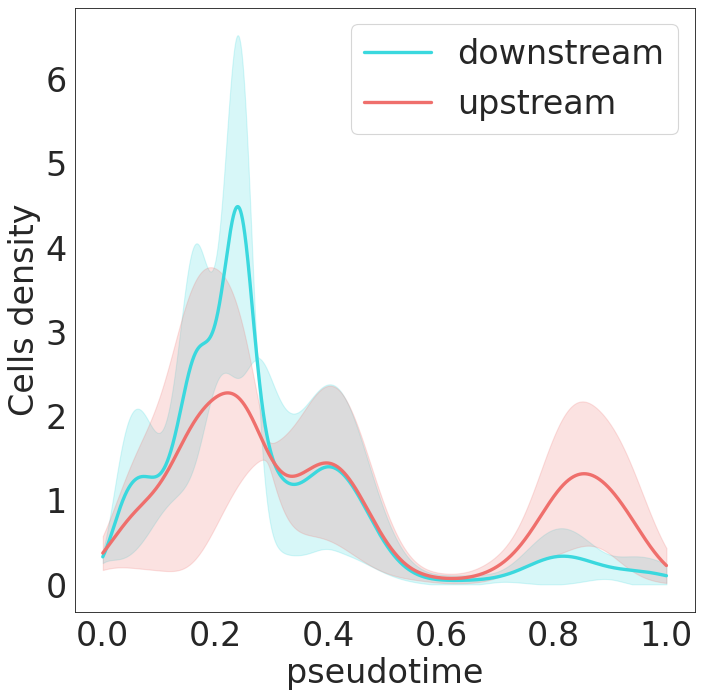

In [24]:
#with errors by dataset
for Stage in adataBranch.obs["type"].unique(): 
    StageLT = adataBranch.obs[adataBranch.obs["type"] == Stage]
    
    StageLT_smoothed = pd.DataFrame(index=np.linspace(0, 1, 10000))
    for dataset in StageLT["dataset"].unique():
        datasetLT = StageLT.loc[StageLT["dataset"] == dataset,timeCov]
        _bandwidth = round((datasetLT.max() - datasetLT.min()) * binWidthRate, 2)

        KernelData = datasetLT

        
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(0, 1, 10000)[:, np.newaxis]

        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        
        StageLT_smoothed[dataset] = Y
        
    StageLT_smoothed["dpt_cut"] = StageLT_smoothed.index.tolist()
        
    # Calculate error and mean on smoothe values ()

    StageLT_smoothed["mean"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].mean(axis =1)
    StageLT_smoothed["stdev"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].std(axis =1)
    StageLT_smoothed["errMin"] = StageLT_smoothed["mean"] - StageLT_smoothed["stdev"]
    StageLT_smoothed["errMax"] = StageLT_smoothed["mean"] + StageLT_smoothed["stdev"]
    StageLT_smoothed["errMin"] = np.where(StageLT_smoothed["errMin"] < 0, 0, StageLT_smoothed["errMin"])
    
    plt.plot(StageLT_smoothed["dpt_cut"], StageLT_smoothed["mean"], '-', label =Stage,linewidth = 3,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["type_colors"]))[Stage])
    plt.fill_between(StageLT_smoothed["dpt_cut"], StageLT_smoothed["errMin"], StageLT_smoothed["errMax"] , alpha=0.2,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["type_colors"]))[Stage])

    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)

    plt.ylabel('Cells density', size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.Up_vs_Down.dpt."+branchTag+".svg")

 

## Explore Genotypes

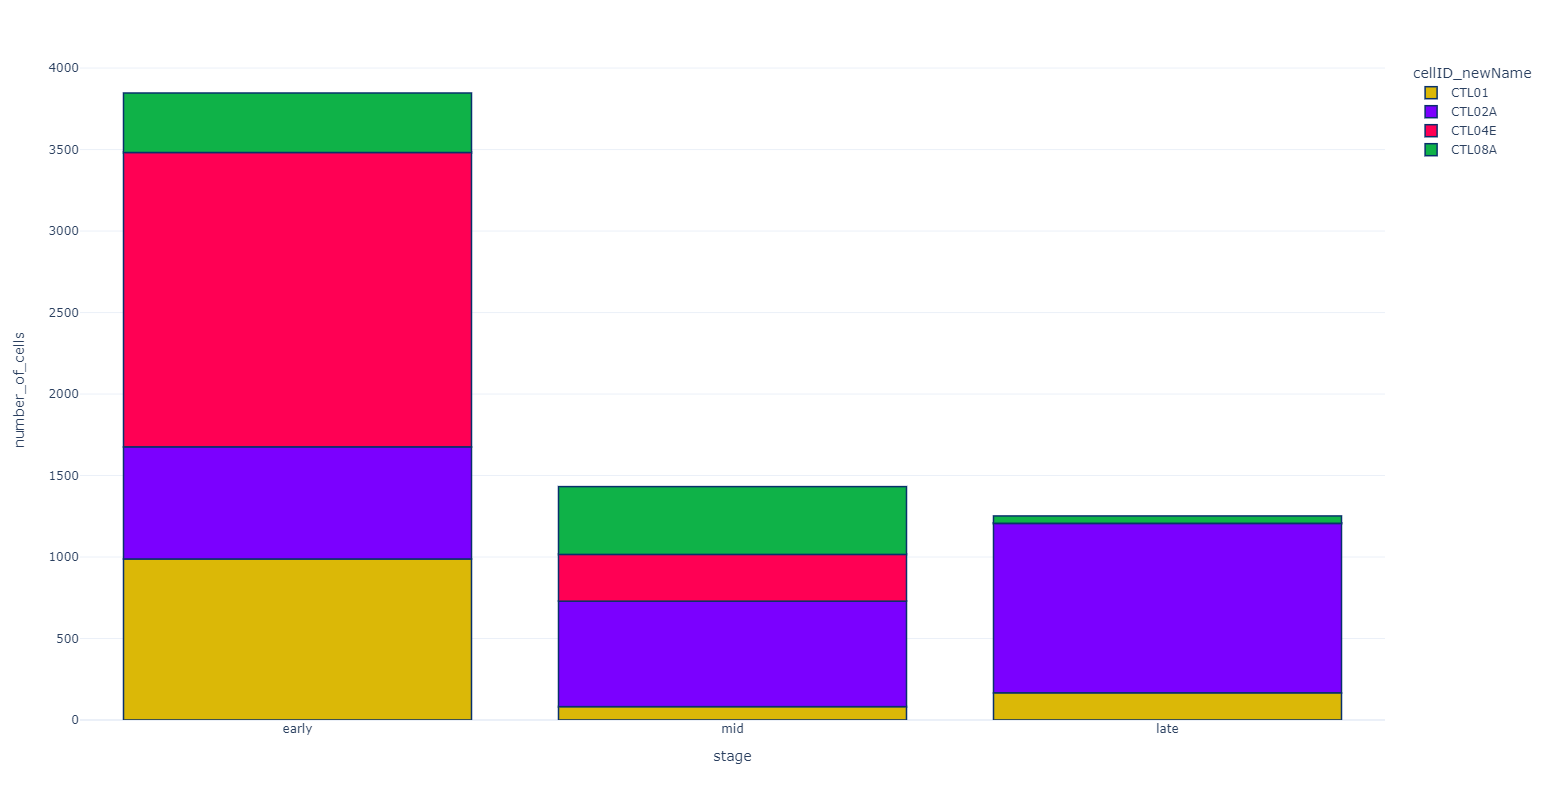

In [25]:
#######---original adata ------- Load Original adata and plot uncorrected PCA and original compositions

sc.settings.verbosity = 0 


adataInitPCA = adataBranch.copy()


compositions = pd.DataFrame(adataInitPCA.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", 
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataInitPCA.obs["cellID_newName"].cat.categories, adataInitPCA.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()


### Downsampling loops

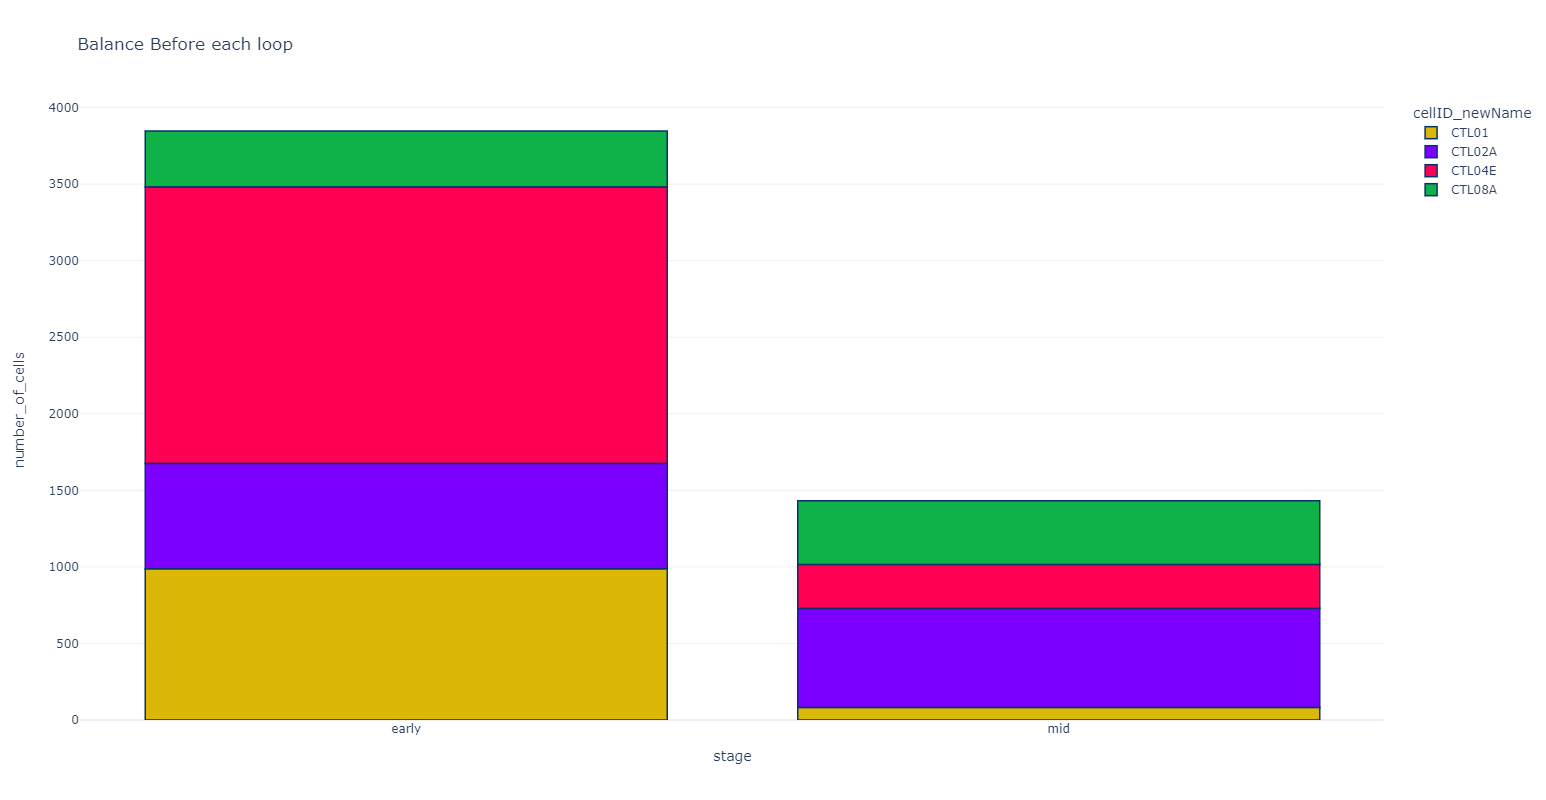

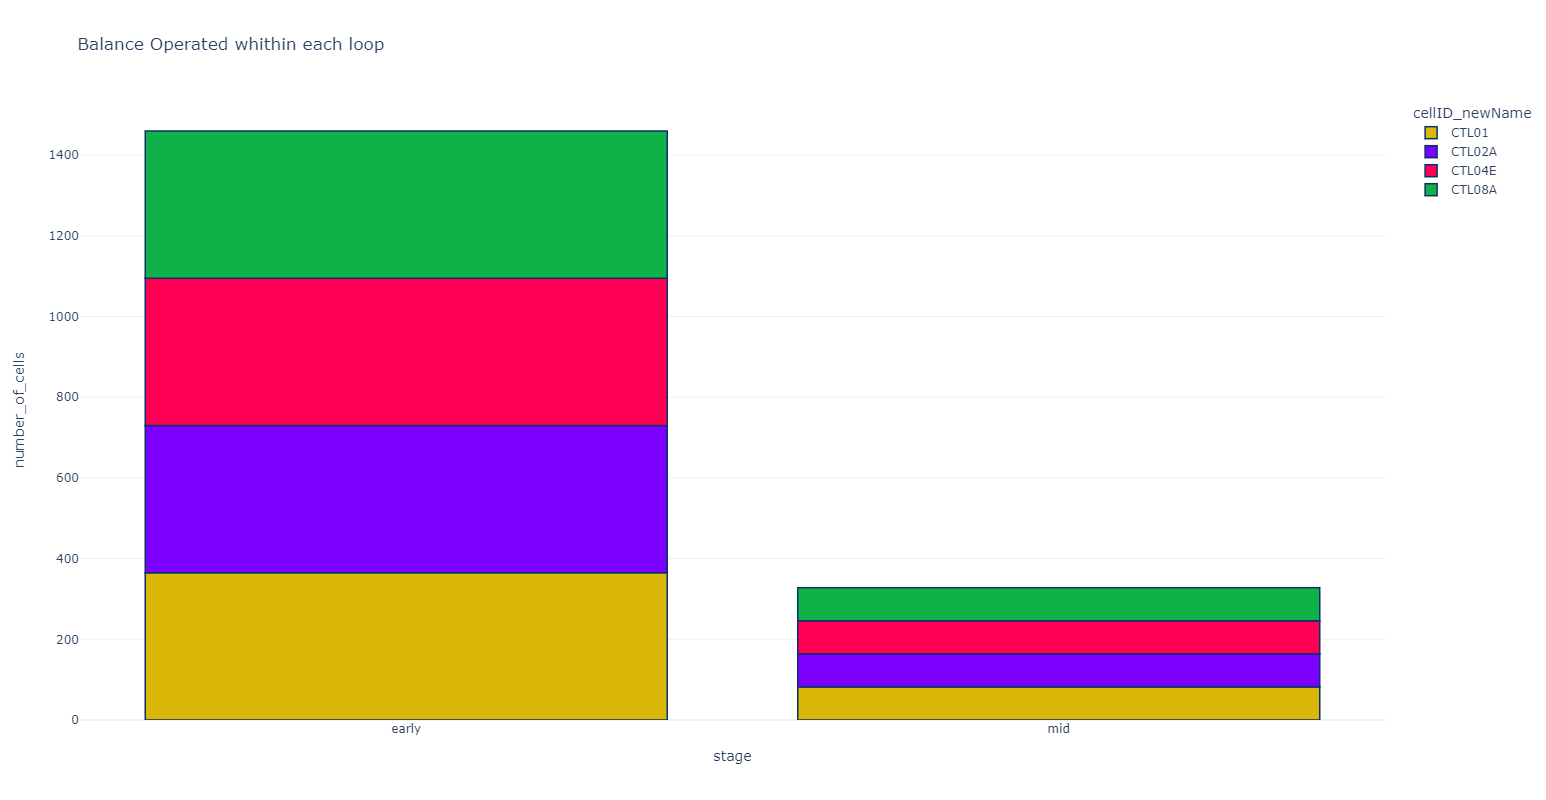

In [26]:
ReproducibilityDF = pd.DataFrame() 
ReproducibilityRaw = pd.DataFrame() 


adataInitPCA = adataInitPCA[adataInitPCA.obs["stage"].isin(MultiTPTstages)]
#Remove genotypes not in all timepoints
GoodIDs = pd.crosstab(adataInitPCA.obs.cellID_newName,adataInitPCA.obs.stage ) > min_cells
GoodIDs = GoodIDs[GoodIDs.sum(axis =1) == len(adataInitPCA.obs["stage"].unique())].index.tolist()
adataInitPCA = adataInitPCA[adataInitPCA.obs.cellID_newName.isin(GoodIDs)]
    
compositions = pd.DataFrame(adataInitPCA.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", title="Balance Before each loop",
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataInitPCA.obs["cellID_newName"].cat.categories, adataInitPCA.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()

    
for seed in range(ResamplingIterations):
    random.seed(seed)
    
    adataGenotypes = adataInitPCA.copy()


    #Subset timepoint if needed
    MinCells = pd.crosstab(adataGenotypes.obs.cellID_newName,adataGenotypes.obs.stage ) 
    MinCells = MinCells.min().to_dict()

    sampledBCs = []
    for stage in adataGenotypes.obs.stage.unique():
        samplingSize = MinCells[stage]
        sampledBCsStage = [ random.sample(adataGenotypes[(adataGenotypes.obs["stage"] == stage) & (adataGenotypes.obs["cellID_newName"] == ID)].obs_names.tolist() ,samplingSize) for ID in adataGenotypes.obs["cellID_newName"].unique().tolist()  ]
        sampledBCsStage = [item for sublist in sampledBCsStage for item in sublist]
        sampledBCs = sampledBCs + sampledBCsStage

    adataGenotypes = adataGenotypes[sampledBCs]
    
    #Trim extreme values
#     trimExtremes = [0.01,.99]
#     minDPT, maxDPT = np.quantile(adataGenotypes.obs["pc1"], trimExtremes)
#     adataGenotypes = adataGenotypes[(adataGenotypes.obs["pc1"] > minDPT) & (adataGenotypes.obs["pc1"] < maxDPT)]
    
    _bandwidth = round((adataGenotypes.obs["dpt_pseudotime"].max() - adataGenotypes.obs["dpt_pseudotime"].min()) * binWidthRate, 2)
    seedPseudotime = pd.DataFrame()
    seedPseudotimeRaw = pd.DataFrame()

    for cellID in adataGenotypes.obs["cellID_newName"].unique(): 
        LocalPseudotime = pd.DataFrame()
        LocalPseudotimeRaw = pd.DataFrame()
        KernelData = adataGenotypes.obs.loc[adataBranch.obs["cellID_newName"] == cellID, "dpt_pseudotime"]
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(adataGenotypes.obs["dpt_pseudotime"].min(), adataGenotypes.obs["dpt_pseudotime"].max(), 10000)[:, np.newaxis]
        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        LocalPseudotime[seed] = Y
        LocalPseudotime["cellID"] = cellID
        LocalPseudotime["x"] = X_plot.flatten()
        seedPseudotime = pd.concat([seedPseudotime,LocalPseudotime ], ignore_index=True, axis = 0)
        #Raw values non smoothed
        LocalPseudotimeRaw[seed] = KernelData.tolist()
        LocalPseudotimeRaw["cellID"] = cellID
        seedPseudotimeRaw = pd.concat([seedPseudotimeRaw,LocalPseudotimeRaw], ignore_index=True)
    if "cellID" in ReproducibilityDF.columns:
        ReproducibilityDF = pd.concat([seedPseudotime[seed], ReproducibilityDF], axis = 1)
        ReproducibilityRaw = pd.concat([seedPseudotimeRaw[seed], ReproducibilityRaw], axis = 1)
    else:
        ReproducibilityDF = pd.concat([ReproducibilityDF, seedPseudotime], axis =1 )
        ReproducibilityRaw = pd.concat([ReproducibilityRaw, seedPseudotimeRaw], axis =1 )
 
        
        
compositions = pd.DataFrame(adataGenotypes.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", title="Balance Operated whithin each loop",
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories, adataGenotypes.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()
        

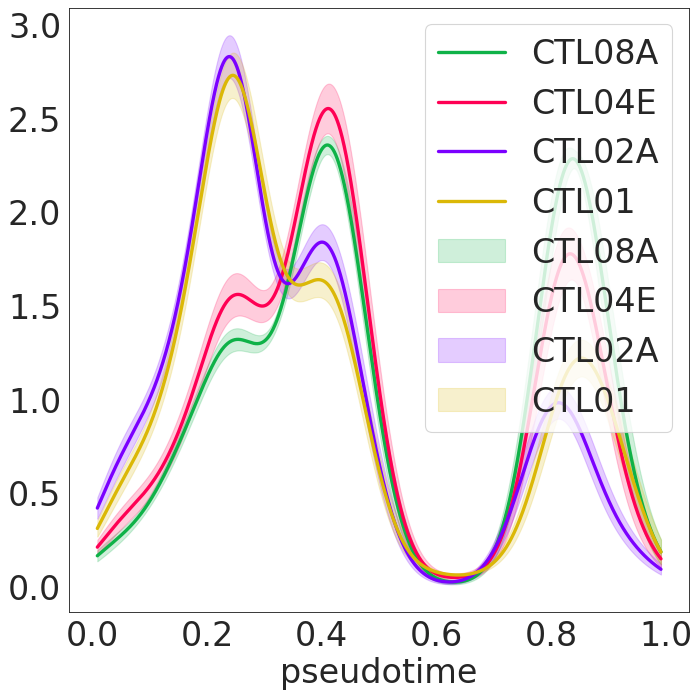

In [27]:

plotDF = ReproducibilityDF.copy()

plotDF["std"] = plotDF[[c for c in plotDF.columns if c not in ["x","cellID","std","mean",'max','min']]].std(axis =1)

plotDF["mean"] = plotDF[[c for c in plotDF.columns if c not in ["x","cellID","std","mean",'max','min']]].mean(axis =1)
plotDF["max"] = plotDF["mean"]+plotDF["std"]
plotDF["min"] = plotDF["mean"]-plotDF["std"]

for g in plotDF.cellID.unique():
    plotDFID = plotDF[plotDF.cellID == g]
    plt.plot(plotDFID["x"], plotDFID["mean"], '-',
             label =g,
             color = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories.tolist(),adataGenotypes.uns["cellID_newName_colors"]))[g],
             linewidth = 3)
    plt.fill_between(plotDFID["x"], plotDFID["min"], plotDFID["max"] , 
                     alpha=0.2,label=g,
                     color = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories.tolist(),adataGenotypes.uns["cellID_newName_colors"]))[g])

    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.Genotypes."+branchTag+".svg")


In [28]:
DPTdf = plotDF.rename(columns=dict(zip([c for c in plotDF.columns if isinstance(c, int)], ["iteration."+str(c) for c in plotDF.columns if isinstance(c, int)]))).rename(columns={"x":"pseudotime_bin"})
DPTdf["Branch"] = branchTag
DPTdf.to_csv(outdir+"/PseudotimeGenotypeDensity."+branchTag+".tsv", index=False, sep="\t")

# Tradeseq within lineage

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


In [30]:
obs = adataBranch.obs
obsm = adataBranch.obsm


adataTradeseq = sc.read_h5ad(outdir+'/adatas/MultiplexingPreprocessing_unscaled.h5ad')[obs.index]
#Sample extra genes to ensure fair unbyased normalization
ExtraNormGenes = random.sample(adataTradeseq.var_names[~adataTradeseq.var_names.isin(HVGs)].tolist(), len(HVGs.tolist()))
adataTradeseq = adataTradeseq[:,HVGs.tolist()+ExtraNormGenes]

adataTradeseq.obs = obs.loc[adataTradeseq.obs_names]
adataTradeseq = adataTradeseq[:,~adataTradeseq.var_names.str.startswith('MT-')]
adataTradeseq = adataTradeseq[:,~adataTradeseq.var_names.str.startswith(("RPS","RPL"))]
adataTradeseq.obsm = obsm
adataTradeseq.uns["leidenAnnotated_colors"] =  adataBranch[adataTradeseq.obs_names].uns["leidenAnnotated_colors"]


#Trim extreme values of DPT (for potentially low amount of cells)
trimExtremes = [0.01,.99]
minDPT, maxDPT = np.quantile(adataTradeseq.obs["dpt_pseudotime"], trimExtremes)
adataTradeseq = adataTradeseq[(adataTradeseq.obs["dpt_pseudotime"] > minDPT) & (adataTradeseq.obs["dpt_pseudotime"] < maxDPT)]

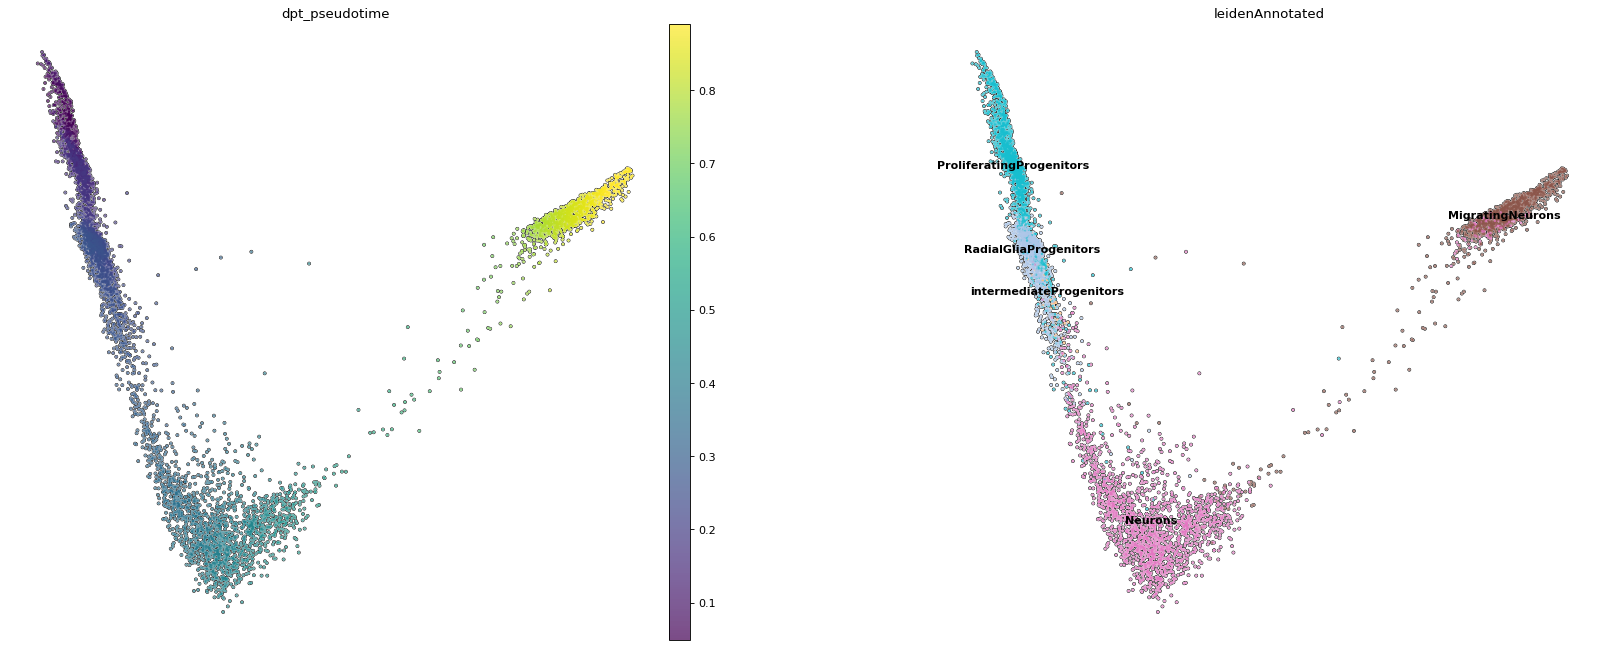

In [31]:

sc.pl.diffmap(adataTradeseq, color = ["dpt_pseudotime","leidenAnnotated"],
           size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', frameon=False, wspace=.3, legend_loc="on data")


In [32]:
adataTradeseq.obs[endpoint] = 1

In [33]:
cellWeights = adataTradeseq.obs[endpoint]
cellWeights = np.matrix(cellWeights.to_numpy()).T


pseudotime = adataTradeseq.obs["dpt_pseudotime"]
pseudotime = np.matrix(pseudotime.to_numpy()).T



# Transpose needed!
counts = adataTradeseq.X.T.todense()
counts = counts + abs(counts.min())

varnames = adataTradeseq.var_names.tolist()

In [34]:
import anndata2ri
import rpy2
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [35]:
%%R -i tradeSeqUtilsPath

source(tradeSeqUtilsPath)


In [36]:
%%R -i cellWeights -i pseudotime -i counts -i varnames
set.seed(8)

library(tradeSeq)
library(ggplot2)


w <- as.matrix(cellWeights)
dpt <- as.matrix(pseudotime)
cMatrix <- as.matrix(counts)


gamObj <- fitGAM(cMatrix, verbose = TRUE, pseudotime = dpt, cellWeights = w, nknots = 8, sce=FALSE)
names(gamObj) <- varnames


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10m 54s       |+                                                 | 2 % ~10m 34s       |++                                                | 3 % ~10m 09s       |++                                                | 4 % ~10m 11s       |+++                                               | 5 % ~09m 51s       |+++                                               | 6 % ~09m 33s       |++++                                              | 7 % ~09m 24s       |++++                                              | 8 % ~09m 18s       |+++++                                             | 9 % ~09m 09s       |+++++                                             | 10% ~09m 01s       |++++++                                            | 11% ~08m 54s       |++++++                                            | 12% ~08m 48s       |+++++++                                           | 13% ~08m 

In [37]:
%%R -i tradeSeqUtilsPath

source(tradeSeqUtilsPath)


In [38]:
dptseq = np.linspace(pseudotime.min(),pseudotime.max(), 5)
nGenes = 3

leidenCols = dict(zip(adataTradeseq.obs.leidenAnnotated.cat.categories, adataTradeseq.uns["leidenAnnotated_colors"]))

In [39]:
%%R   -o startRes -i minDPT -i maxDPT


startRes <- startVsEndTest(gamObj, pseudotimeValues = c(minDPT+.01,maxDPT-.01))


In [40]:
# Top Up and Down
startResFilt = startRes[(startRes.pvalue <= 0.001) & (abs(startRes.logFClineage1) >= 2)]
startResFilt["Gene"] = startResFilt.index.tolist()
startResFilt["test"] = "startVsEndTest"
startResGenesPositive = startResFilt[startResFilt.logFClineage1 < 0 ].sort_values(["pvalue","logFClineage1"], ascending=[True,True])
startResGenesPositive_plot = startResGenesPositive.head(nGenes).index.tolist()
startResGenesPositive["PatternType"] = "decreasing"
startResGenesPositive = startResGenesPositive.rename(columns={"logFClineage1":"logFC"})

startResGenesNegatives = startResFilt[startResFilt.logFClineage1 > 0 ].sort_values(["pvalue","logFClineage1"], ascending=[True,False])
startResGenesNegatives_plot = startResGenesNegatives.head(nGenes).index.tolist()
startResGenesNegatives["PatternType"] = "increasing"
startResGenesNegatives = startResGenesNegatives.rename(columns={"logFClineage1":"logFC"})





In [41]:
CombinedDF = pd.concat([startResGenesPositive,startResGenesNegatives], ignore_index=True)
CombinedDF["Branch"] = branchTag
CombinedDF.to_csv(outdir+"/Tradeseq."+branchTag+".tsv", sep="\t", index=False)

In [42]:
%%R  -i startResGenesPositive_plot -i startResGenesNegatives_plot -o assoResSSPandas

CombinedList <- c(startResGenesPositive_plot,startResGenesNegatives_plot)

datalist <- list()
for (g in CombinedList){
    
    localModel <- gamObj[[g]]    
    data <- localModel$model    
    y <- data$y
    nCurves <- length(localModel$smooth)

    for (jj in seq_len(nCurves)) {
        df <- .getPredictRangeDf(localModel$model, jj, nPoints = 100)
        yhat <- predict(localModel, newdata = df, type = "response")

        Newframe <- data.frame("fittedCounts" = yhat)
        colnames(Newframe) <- c(paste0("fittedCounts.",g))

        datalist[[paste(g,jj)]] <- Newframe

        
        

    }

}

assoResSSPandas =  do.call(cbind, datalist)


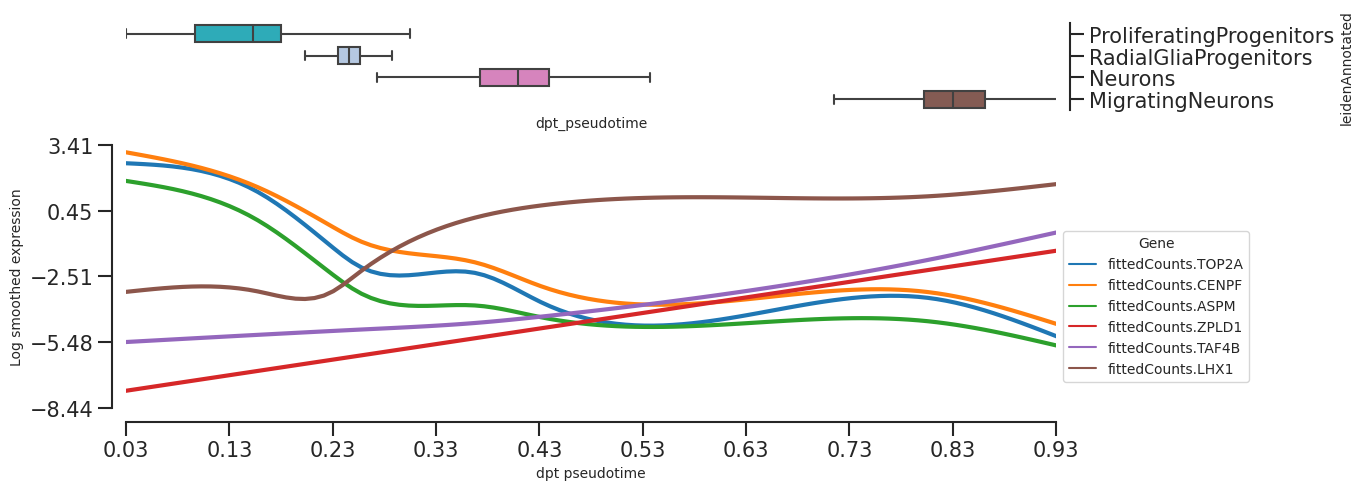

In [43]:
#Curatedmarkerslist = CuratedmarkersDF.loc[CuratedmarkersDF.score > 1,"name"].tolist()
#CuratedmarkersDF = pd.read_csv(markers, header=None, sep = "\t", names=["name","area","score"])
#Curatedmarkerslist = CuratedmarkersDF.loc[CuratedmarkersDF.score >= 1,"name"].tolist()

##############################


###################à
plt.rcdefaults()

sns.set_style("ticks", {'axes.grid' : False})


fig, axes = plt.subplots(2,1, figsize=(12,5),sharex=True, 
                         gridspec_kw={'height_ratios': [1, 3]})

sns.boxplot(data=adataTradeseq.obs, x="dpt_pseudotime", y="leidenAnnotated", ax = axes[0],
            palette=leidenCols,
            showfliers=False,order=leidenOrder)

    

    
    


#fig, axes = plt.subplots(2,1, figsize=(10,5),sharex=True, 
#                         gridspec_kw={'height_ratios': [1, 2]})

#sns.histplot(data=adataTradeseq.obs, x="dpt_pseudotime", hue="leidenAnnotated", ax=axes[0])

# sns.histplot(data=adataTradeseq.obs, x="dpt_pseudotime", hue="leidenAnnotated", ax=axes[0],bins=100,
#               palette=dict(zip(adata.obs.leidenAnnotated.cat.categories, adata.uns["leidenAnnotated_colors"])), alpha=.5)




SmoothedExpr = assoResSSPandas.copy()
SmoothedExpr["pseudotime"] = SmoothedExpr.index.tolist()      
SmoothedExpr["pseudotime"] =  np.linspace(pseudotime.min(),pseudotime.max(), 100)
SmoothedExpr = SmoothedExpr.melt("pseudotime")
SmoothedExpr["value"] = np.log(SmoothedExpr["value"])


#TrimExtremes


sns.lineplot(data=SmoothedExpr, x="pseudotime", y="value", hue= "variable",  linewidth=3, ax=axes[1])
#axes[1].lines[1].set_linestyle("--")





dptAxis = np.linspace(SmoothedExpr.pseudotime.min(), SmoothedExpr.pseudotime.max(), 10).round(2)      
ylimits = np.array([SmoothedExpr.value.min()-abs((SmoothedExpr.value.min()*.1)), 
                    SmoothedExpr.value.max()+abs((SmoothedExpr.value.max()*.1))]).round(2)
exprAxis = np.linspace(ylimits.min(), ylimits.max(),5).round(2)


axes[1].set_xlim([dptAxis.min(), dptAxis.max()])
axes[1].set_ylim(ylimits)


axes[0].yaxis.tick_right()
axes[0].spines[['left', 'top','bottom']].set_visible(False)
axes[0].spines['right'].set_linewidth(1.5)
axes[0].tick_params(axis='y', which='major', labelsize=15, width=1.5, length=10)
axes[0].tick_params(axis='x', which='major', labelsize=15, width=0, length=10)


axes[1].set_xticks(dptAxis)
axes[1].set_yticks(exprAxis)

axes[1].spines['left'].set_linewidth(1.5)
axes[1].spines['bottom'].set_linewidth(1.5)
axes[1].tick_params(axis='both', which='major', labelsize=15, width=1.5, length=10)
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].xaxis.tick_bottom()
axes[1].yaxis.tick_left()
axes[1].legend(title='Gene', bbox_to_anchor=(1, .7))


sns.despine(ax=axes[1], top=True, right=True, left=False, bottom=False, offset=10, trim=False)
sns.despine(ax=axes[0], top=True, right=False, left=False, bottom=True, offset=10, trim=False)
axes[0].yaxis.set_label_position("right")
axes[0].spines[['left', 'top','bottom']].set_visible(False)

axes[1].set(xlabel='dpt pseudotime', ylabel='Log smoothed expression')



fig.show()
        


fig.savefig(figDir+'/TopGenes.'+branchTag+'.pdf',bbox_inches='tight')

# Import VCF and Map snps to genes

In [44]:
lineage1 = ["CTL08A","CTL04E"]
lineage2 = ["CTL02A","CTL01"]


In [45]:
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x for x in line.split('\t')]
                  break
    ifile.close()
    return vcf_names

names = [i.replace("#","").replace('\n','') for i in get_vcf_names(vcfPath)] 
mappings = {k: v for d in [{k:iPSC_lines_map[k]["newName"]} for k in list(iPSC_lines_map.keys())] for k, v in d.items()}


vcf = pd.read_csv(vcfPath, sep="\t", skip_blank_lines=True,comment='#', names=names).rename(columns = mappings)
vcf = vcf[~vcf[adataBranch.obs.cellID_newName.unique().tolist()].apply(lambda r: r.str.contains('./.',regex=False).any(), axis=1)]

MappedVars = vcf.copy()
MappedVars["Chromosome"] = "chr"+vcf["CHROM"].astype(str)
MappedVars["End"] = MappedVars["POS"]
MappedVars["Start"] = MappedVars["POS"]
MappedVars = MappedVars[["Chromosome","Start","End","CHROM"]]
MappedVars = pr.PyRanges(MappedVars)
MappedVars

#Prepare gtf for overlap, we exclude non genes features and keep only coding genes
gtf = pd.read_csv(gtfPath, sep="\t", comment='#', header=None)
gtf = gtf[gtf[2] == "gene"]
gtf['GENE'] = gtf[8].str.extract(r'gene_name "(.+?)";')
gtf['GENEtype'] = gtf[8].str.extract(r'gene_type "(.+?)";')
gtf = gtf[gtf['GENEtype'] == "protein_coding"]
gtf = gtf[[0,3,4,"GENE"]]
gtf.columns = ["Chromosome","Start","End","SYMBOL"]
gtf = pr.PyRanges(gtf)
gtf

MappedVars = MappedVars.join(gtf).df.drop_duplicates(subset=["Chromosome","Start","End"]).drop(columns=["Start_b","End_b"])
MappedVars.index = MappedVars["CHROM"].astype(str)+"_"+MappedVars["Start"].astype(str)
MappedVars["indexer"] = MappedVars.index.tolist()

vcf.index  = vcf["CHROM"].astype(str)+"_"+vcf["POS"].astype(str)
MappedVars["REF"] = vcf.loc[MappedVars.index,"REF"]
MappedVars["ALT"] = vcf.loc[MappedVars.index,"ALT"]

In [46]:
# Now we start  refining DF to spot different allelic landscape
LineagesAlleles = vcf[adataBranch.obs.cellID_newName.unique().tolist()]
LineagesAlleles = LineagesAlleles.apply(lambda col: col.str.split(":", expand=True)[0], axis = 0)

L1DF = LineagesAlleles[lineage1].apply(lambda row: set(row.tolist()), axis = 1)
L1DF = L1DF[L1DF.apply(lambda row: len(row)) == 1].to_frame(name = "_".join(lineage1)+"(L1).alleles")
L1DF["_".join(lineage1)+"(L1).alleles"] = L1DF.apply(lambda row: "".join(list(row[0])), axis = 1)


L2DF = LineagesAlleles[lineage2].apply(lambda row: set(row.tolist()), axis = 1)
L2DF = L2DF[L2DF.apply(lambda row: len(row)) == 1].to_frame(name = "_".join(lineage2)+"(L2).alleles")
L2DF["_".join(lineage2)+"(L2).alleles"] = L2DF.apply(lambda row: "".join(list(row[0])), axis = 1)

LineagesAlleles = pd.concat([L1DF,L2DF], axis = 1).dropna()
LineagesAlleles = LineagesAlleles[LineagesAlleles["_".join(lineage1)+"(L1).alleles"] != LineagesAlleles["_".join(lineage2)+"(L2).alleles"]]

LineagesAlleles

LineagesAlleles = LineagesAlleles.join(MappedVars, how="left")
LineagesAlleles["REF"] = vcf.loc[LineagesAlleles.index.tolist(),'REF']
LineagesAlleles["ALT"] = vcf.loc[LineagesAlleles.index.tolist(),'ALT']
LineagesAlleles

CTL08A_CTL04E(L1).alleles CTL02A_CTL01(L2).alleles Chromosome  \
1_1728604                         0/1                      0/0       chr1   
1_6469383                         0/0                      0/1       chr1   
1_6623180                         0/0                      0/1       chr1   
1_6635271                         0/0                      0/1       chr1   
1_11519447                        0/1                      0/0       chr1   
...                               ...                      ...        ...   
X_149482521                       0/1                      0/0       chrX   
X_154473373                       1/1                      0/0       chrX   
X_154477925                       0/0                      1/1       chrX   
X_154484549                       1/1                      0/0       chrX   
X_154506456                       1/1                      0/0       chrX   

                   Start          End CHROM    SYMBOL      indexer REF    ALT  
1_1728604      1728604.0    1728604.0     1  SLC35E2A    1_1728604   T      A  
1_6469383      6469383.0    6469383.0     1   PLEKHG5    1_6469383   A      G  
1_6623180      6623180.0    6623180.0     1     PHF13    1_6623180   G      A  
1_6635271      6635271.0    6635271.0     1     THAP3    1_6635271   G      T  
1_11519447    11519447.0   11519447.0     1     DISP3   1_11519447   G      C  
...                  ...          ...   ...       ...          ...  ..    ...  
X_149482521  149482521.0  149482521.0     X       IDS  X_149482521  TA  TAA,T  
X_154473373  154473373.0  154473373.0     X    PLXNA3  X_154473373   G      A  
X_154477925  154477925.0  154477925.0     X     LAGE3  X_154477925   C      G  
X_154484549  154484549.0  154484549.0     X     UBL4A  X_154484549   T      C  
X_154506456  154506456.0  154506456.0     X     FAM3A  X_154506456   A      T  

[1035 rows x 10 columns]

### Port jerber's eQTL data to hg38

In [47]:
def liftOverDF(inDF, chrKey,posKey,indexerKey, oldref="hg19", newref="hg38"):

    lo = LiftOver(oldref, newref)
    


    Liftedvariants = []
    
    __inDF = inDF.copy()
    __inDF[chrKey] = __inDF[chrKey].astype(str)
    
    
    if not __inDF[chrKey].head(1).tolist()[0].startswith("chr"):
        chrRoot = False
        __inDF[chrKey] = "chr"+__inDF[chrKey].astype(str)
    else:
        chrRoot = True
    

    for row in __inDF.index.tolist():

        pos = __inDF.loc[row]
        
        
        posLiftedStart = lo.convert_coordinate(str(pos[chrKey]), pos[posKey])

        if len(posLiftedStart) == 1:

            Liftedvariants.append([posLiftedStart[0][0], posLiftedStart[0][1],  row])
            
    LiftedEnhancers = pd.DataFrame(Liftedvariants, columns=["lifted_"+chrKey,"lifted_"+posKey,"indexRow"])
    LiftedEnhancers.index = LiftedEnhancers["indexRow"]
    
    outDF = pd.merge(__inDF,LiftedEnhancers, how="inner", left_index=True, right_index=True)
    outDF["old_"+chrKey] = outDF[chrKey].astype(str).str.split("chr", expand = True)[1] if not chrRoot else outDF[chrKey]
    outDF["old_"+posKey] = outDF[posKey]
    
    
    outDF[chrKey] = outDF["lifted_"+chrKey].astype(str).str.split("chr", expand = True)[1] if not chrRoot else outDF["lifted_"+chrKey].astype(str)
    outDF[posKey] = outDF["lifted_"+posKey]
    outDF["old_"+indexerKey] = outDF[indexerKey].str.split("chr", expand = True)

    outDF[indexerKey] = outDF[chrKey]+"_"+outDF["lifted_"+posKey].astype(str)
    
    outDF.drop(columns=["lifted_"+chrKey,"lifted_"+posKey], inplace=True)


    return(outDF)

In [48]:
scEqtlsJerber["indexer"] = scEqtlsJerber["snp_chromosome"].astype(str)+"_"+scEqtlsJerber["snp_position"].astype(str)

scEqtlsJerberLifted = liftOverDF(scEqtlsJerber, chrKey="snp_chromosome",posKey="snp_position",indexerKey="indexer", oldref="hg19", newref="hg38")


In [49]:
mergedDFjERBER = scEqtlsJerberLifted[["snp_id","indexer", "assessed_allele", "hgnc_symbol","beta" ]].merge(LineagesAlleles, on="indexer")

In [50]:
mergedDFjERBER

snp_id      indexer assessed_allele hgnc_symbol      beta  \
0   17_36689228_T_C  17_38532993               C      SRCIN1  0.362000   
1   17_36689228_T_C  17_38532993               C      SRCIN1  0.600568   
2   17_36689220_A_G  17_38532985               G      SRCIN1  0.788592   
3   17_44833217_C_A  17_46755851               A         NSF  0.168382   
4    16_1819433_G_A   16_1769432               A      MRPS34  0.229730   
5    16_1819433_G_A   16_1769432               A      MRPS34  0.297822   
6    20_7962128_C_T   20_7981481               T        TMX4  0.576073   
7     7_6502367_T_C    7_6462736               C      KDELR2 -0.287541   
8     7_6502367_T_C    7_6462736               C      KDELR2 -0.470769   
9     7_6502367_T_C    7_6462736               C      KDELR2 -0.410403   
10    7_6502367_T_C    7_6462736               C      KDELR2 -0.397031   
11  6_114183884_A_G  6_113862707               G      MARCKS -0.088814   
12  3_120114914_G_A  3_120396067               A       FSTL1  0.251080   
13  7_128142023_A_T  7_128501969               T     METTL2B -0.243685   
14   3_49052785_T_A   3_49015352               A       ARIH2  0.228237   
15  8_144662353_G_A  8_143580183               A      MROH6  -0.311070   

   CTL08A_CTL04E(L1).alleles CTL02A_CTL01(L2).alleles Chromosome        Start  \
0                        0/0                      0/1      chr17   38532993.0   
1                        0/0                      0/1      chr17   38532993.0   
2                        0/0                      0/1      chr17   38532985.0   
3                        0/1                      0/0      chr17   46755851.0   
4                        0/0                      0/1      chr16    1769432.0   
5                        0/0                      0/1      chr16    1769432.0   
6                        0/0                      0/1      chr20    7981481.0   
7                        0/0                      0/1       chr7    6462736.0   
8                        0/0                      0/1       chr7    6462736.0   
9                        0/0                      0/1       chr7    6462736.0   
10                       0/0                      0/1       chr7    6462736.0   
11                       0/1                      0/0       chr6  113862707.0   
12                       0/1                      1/1       chr3  120396067.0   
13                       0/0                      0/1       chr7  128501969.0   
14                       0/1                      0/0       chr3   49015352.0   
15                       1/1                      0/1       chr8  143580183.0   

            End CHROM    SYMBOL REF ALT  
0    38532993.0    17    SRCIN1   T   C  
1    38532993.0    17    SRCIN1   T   C  
2    38532985.0    17    SRCIN1   A   G  
3    46755851.0    17       NSF   C   A  
4     1769432.0    16  MAPK8IP3   G   A  
5     1769432.0    16  MAPK8IP3   G   A  
6     7981481.0    20      TMX4   C   T  
7     6462736.0     7     DAGLB   T   C  
8     6462736.0     7     DAGLB   T   C  
9     6462736.0     7     DAGLB   T   C  
10    6462736.0     7     DAGLB   T   C  
11  113862707.0     6    MARCKS   A   G  
12  120396067.0     3     FSTL1   G   A  
13  128501969.0     7   METTL2B   A   T  
14   49015352.0     3      WDR6   T   A  
15  143580183.0     8     EEF1D   G   A

In [51]:
print("{} loci found to have different allelic set among the two lineages and previously described as SCeQTLs ".format(len(mergedDFjERBER.indexer.unique())))


11 loci found to have different allelic set among the two lineages and previously described as SCeQTLs 


In [52]:
mergedDFjERBER.to_csv(outdir+"/MatchedSCeQTLs.tsv", sep="\t",index=False )

original snp_id referso to hg19 position that's why the position discrepancy with lifted over coordinates

In [53]:
# Check among sceqtl genes the ones relevant (HVGs) for the isolated branch

In [54]:
set(mergedDFjERBER.hgnc_symbol).intersection(set(TopLoadings.index.tolist()))

{'SRCIN1'}

# Check variance for SRCIN1

In [55]:
TopLoadings["rank"] = TopLoadings["loading"].rank()
TopLoadings["Zero"] = 0

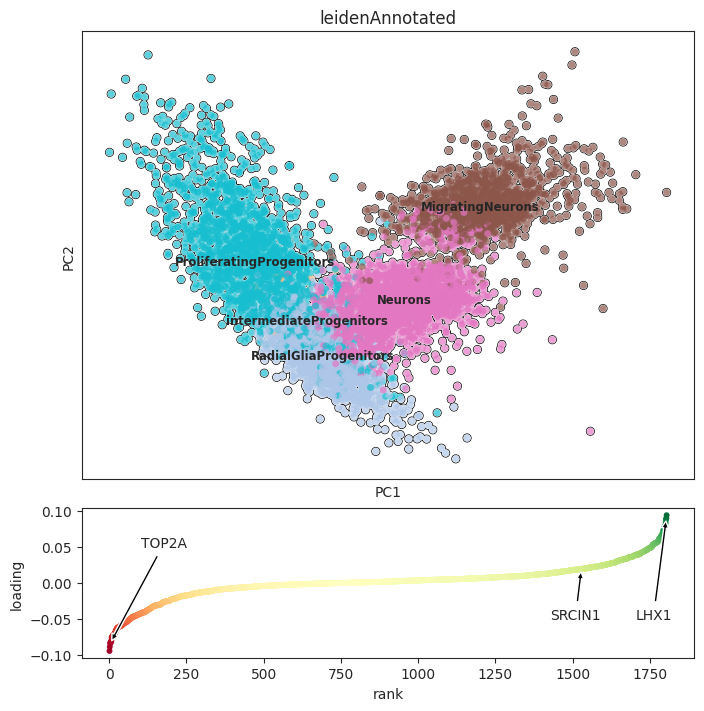

In [56]:
#if you want vector sc.settings._vector_friendly = False
sns.set_style("ticks")
vector=True
n=20
pdDict = {}
pylab.rcParams['figure.figsize'] = (10, 10)

if vector:
    sc.settings._vector_friendly = False
for pc in  [0,1]:
    TopPC_IDX = np.argpartition(adataBranch.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataBranch.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataBranch.varm["PCs"][:,pc][TopPC_IDX], index = adataBranch.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataBranch.varm["PCs"][:,pc][DownPC_IDX], index = adataBranch.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == 0:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == 1:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (6, 6)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize,gridspec_kw={'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataBranch, components=['1,2'], color=["leidenAnnotated"], 
                    ncols=1, add_outline=True, legend_loc="on data",size=100,legend_fontsize="small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0])



colors = [plt.cm.RdYlGn(norm(c)) for c in TopLoadings["loading"]]
sns.scatterplot(data=TopLoadings, x="rank", y="loading", linewidth=0, hue = "rank",palette=colors, size=.1, ax=ax[1], alpha=1)

for i in ["SRCIN1","TOP2A","LHX1"]:
    offsety =  -.05 if TopLoadings.loc[i,"loading"] > 0 else .05
    offsetx =  -100 if TopLoadings.loc[i,"loading"] > 0 else 100
    ax[1].annotate(i, 
                xy=(TopLoadings.loc[i,"rank"],TopLoadings.loc[i,"loading"]),
                xytext=(TopLoadings.loc[i,"rank"] + offsetx, offsety),
    xycoords='data',
    arrowprops=dict(arrowstyle="simple",facecolor="black",))

ax[1].get_legend().remove()




sc.settings._vector_friendly = True
pylab.rcParams['figure.figsize'] = (4, 4)

In [57]:
fig.savefig(figDir+"/SRCINlloadings.PCA.pdf",
           bbox_inches="tight")

# genomic plot

In [58]:
mergedDFjERBER.drop_duplicates("indexer")

snp_id      indexer assessed_allele hgnc_symbol      beta  \
0   17_36689228_T_C  17_38532993               C      SRCIN1  0.362000   
2   17_36689220_A_G  17_38532985               G      SRCIN1  0.788592   
3   17_44833217_C_A  17_46755851               A         NSF  0.168382   
4    16_1819433_G_A   16_1769432               A      MRPS34  0.229730   
6    20_7962128_C_T   20_7981481               T        TMX4  0.576073   
7     7_6502367_T_C    7_6462736               C      KDELR2 -0.287541   
11  6_114183884_A_G  6_113862707               G      MARCKS -0.088814   
12  3_120114914_G_A  3_120396067               A       FSTL1  0.251080   
13  7_128142023_A_T  7_128501969               T     METTL2B -0.243685   
14   3_49052785_T_A   3_49015352               A       ARIH2  0.228237   
15  8_144662353_G_A  8_143580183               A      MROH6  -0.311070   

   CTL08A_CTL04E(L1).alleles CTL02A_CTL01(L2).alleles Chromosome        Start  \
0                        0/0                      0/1      chr17   38532993.0   
2                        0/0                      0/1      chr17   38532985.0   
3                        0/1                      0/0      chr17   46755851.0   
4                        0/0                      0/1      chr16    1769432.0   
6                        0/0                      0/1      chr20    7981481.0   
7                        0/0                      0/1       chr7    6462736.0   
11                       0/1                      0/0       chr6  113862707.0   
12                       0/1                      1/1       chr3  120396067.0   
13                       0/0                      0/1       chr7  128501969.0   
14                       0/1                      0/0       chr3   49015352.0   
15                       1/1                      0/1       chr8  143580183.0   

            End CHROM    SYMBOL REF ALT  
0    38532993.0    17    SRCIN1   T   C  
2    38532985.0    17    SRCIN1   A   G  
3    46755851.0    17       NSF   C   A  
4     1769432.0    16  MAPK8IP3   G   A  
6     7981481.0    20      TMX4   C   T  
7     6462736.0     7     DAGLB   T   C  
11  113862707.0     6    MARCKS   A   G  
12  120396067.0     3     FSTL1   G   A  
13  128501969.0     7   METTL2B   A   T  
14   49015352.0     3      WDR6   T   A  
15  143580183.0     8     EEF1D   G   A

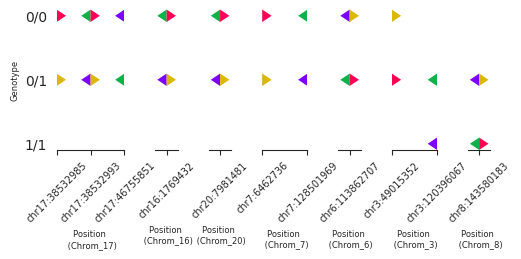

In [59]:
fig, ax = plt.subplots(nrows=1, ncols= len(mergedDFjERBER.CHROM.unique()), 
                       figsize= (5,2),gridspec_kw={'width_ratios': mergedDFjERBER.drop_duplicates("indexer").groupby("CHROM").size()[mergedDFjERBER.CHROM.unique()].tolist()},
                       sharex=False, sharey=True)

fig.tight_layout(h_pad=30000)

for chrom in zip(mergedDFjERBER.CHROM.unique(),ax ):
    chromMerged = mergedDFjERBER.loc[mergedDFjERBER.CHROM == chrom[0], ["Chromosome","Start", "CTL08A_CTL04E(L1).alleles","CTL02A_CTL01(L2).alleles","indexer"]]
    chromMerged = chromMerged.drop_duplicates("indexer")
    chromMerged = chromMerged.drop(columns="indexer")
    chromMerged = chromMerged.melt(["Start","Chromosome"])
    chromMerged["RankedPosition"] = chromMerged["Start"].rank()
    chromMerged = chromMerged.sort_values("RankedPosition")
    
    chromMerged = pd.concat([chromMerged.assign(Symbol=8).assign(genotype=chromMerged.variable.str.split("_", expand=True)[0]),chromMerged.assign(Symbol=9).assign(genotype=chromMerged.variable.str.split("_", expand=True)[1].str.split("(", expand=True)[0])], axis = 0, ignore_index=True)
    

    

    chromMerged["value"] = chromMerged.value.astype("category")
    sns.scatterplot(data=chromMerged, x = "RankedPosition" , y = "value", hue="genotype",
                    ax=chrom[1], s=80,linewidth=0,edgecolor="black", palette=cellIDColorsMap, 
                    style="Symbol", markers=dict(zip(chromMerged.Symbol, chromMerged.Symbol)))
    chrom[1].get_legend().remove()
    chrom[1].set_xticks(chromMerged["RankedPosition"].unique().tolist())
    
    
    
    chrom[1].set_xticklabels(["chr"+str(chrom[0])+":"+ str(Start) for Start in chromMerged["Start"].astype(int).unique().tolist()],rotation=45, fontsize=7)
    chrom[1].tick_params(left=False)
    chrom[1].spines[['left', 'top','right']].set_visible(False)
    chrom[1].set_xlim([chromMerged["RankedPosition"].min(), chromMerged["RankedPosition"].max()])
    chrom[1].set_xlabel(xlabel="Position \n (Chrom_"+str(chrom[0])+")", fontsize = 6)
    chrom[1].set_ylabel(ylabel="Genotype", fontsize = 6)


fig.savefig(figDir+'/DifferentAlleles.pdf',bbox_inches='tight')
    